In [2]:
import numpy as np
import torch
import os
from lib.models import iVAE
from lib.iFlow import iFlow
from lib.metrics import mean_corr_coef as mcc
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

from lib.data import DataLoaderGPU

In [3]:
ROOT_DIR = (os.path.abspath(''))
MODEL_DIR = os.path.join(ROOT_DIR, "pt_models")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(ROOT_DIR)

/home/feng/Desktop/iFlow


In [10]:
def correlation_coefficients(x, y, method='pearson'):
    """
    A numpy implementation of the mean correlation coefficient metric.

    :param x: numpy.ndarray
    :param y: numpy.ndarray
    :param method: str, optional
            The method used to compute the correlation coefficients.
                The options are 'pearson' and 'spearman'
                'pearson':
                    use Pearson's correlation coefficient
                'spearman':
                    use Spearman's nonparametric rank correlation coefficient
    :return: float
    """
    d = x.shape[1]
    if method == 'pearson':
        cc = np.corrcoef(x, y, rowvar=False)[:d, d:]
    else:
        raise ValueError('not a valid method: {}'.format(method))
    cc_matrix = np.abs(cc)

    corr_coefs = cc_matrix[linear_sum_assignment(-1 * cc_matrix)] #.mean()
    return corr_coefs

# Run model and create dataset (only once)

### Fill in script arguments

In [5]:
# Specify dataset string (same as first argument in python main.py command)
seed = 49
data_args = "1000_40_5_5_3_" + str(seed) + "_gauss_xtanh_u_f"
batch_size = 64
epochs = 20
i_what = 'iVAE' # 'iVAE' or 'iFLow'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### Run model

In [5]:
!python main_save_mcc.py --data-args=$data_args --epochs=$epochs --batch-size=$batch_size --i-what=$i_what --cuda --flow_type=RQNSF_AG --nat_param_act=Softplus --preload-gpu --lr_drop_factor=0.25

Namespace(anneal=False, batch_size=64, cuda=True, data_args='1000_40_5_5_3_48_gauss_xtanh_u_f', depth=3, epochs=20, file=None, flow_length=10, flow_type='RQNSF_AG', gpu_id='0', hidden_dim=50, i_what='iVAE', latent_dim=None, log_freq=25, lr=0.001, lr_drop_factor=0.25, lr_patience=10, max_iter=None, nat_param_act='Softplus', no_log=False, num_bins=8, preload=True, seed=1)
training on GeForce GTX 950M
data loaded on cuda
setup time: 1.684539556503296s
Beginning training for exp: 1
.. checkpoint at iteration 0 ..
epoch 1: 5.1335s;	loss: 2.9230;	perf: 0.5336
epoch 2: 4.8616s;	loss: 1.8266;	perf: 0.5622
epoch 3: 4.9850s;	loss: 1.5874;	perf: 0.5446
Epoch    88: reducing learning rate of group 0 to 2.5000e-04.
epoch 4: 5.1455s;	loss: 1.3088;	perf: 0.5339
.. checkpoint at iteration 2500 ..
Epoch   113: reducing learning rate of group 0 to 6.2500e-05.
epoch 5: 5.1356s;	loss: 1.2111;	perf: 0.5296
Epoch   129: reducing learning rate of group 0 to 1.5625e-05.
Epoch   148: reducing learning rate of 

### Load model checkpoint

In [7]:
DATA_PATH = "data/1/" + "tcl_" + data_args[:-2] + ".npz"
print("DATA_PATH =", DATA_PATH)
# DATA_PATH = "data/1/tcl_100_40_5_5_3_1_gauss_xtanh_u.npz"

# Arguments (metadata, from argparse in main.py) have to correspond to selected dataset and model properties
metadata = {'file': DATA_PATH, 'path':DATA_PATH, 'batch_size': batch_size, 
            'epochs': epochs, 'device': device, 'seed': 1, 'i_what': i_what,
            
            'max_iter': None, 'hidden_dim': 50, 'depth': 3, 
            'lr': 1e-3, 'cuda': True, 'preload': True, 
            'anneal': False, 'log_freq': 25,  
            'flow_type': 'RQNSF_AG', 'num_bins': 8, 
            'nat_param_act': 'Softplus', 'gpu_id': '0', 
            'flow_length': 10, 'lr_drop_factor': 0.25, 
            'lr_patience': 10}

# Get arguments for dataset properties
train_loader = DataLoaderGPU(DATA_PATH, shuffle=True, batch_size=batch_size)
data_dim, latent_dim, aux_dim = train_loader.get_dims()
metadata.update(train_loader.get_metadata())

DATA_PATH = data/1/tcl_1000_40_5_5_3_49_gauss_xtanh_u.npz
data loaded on cuda


### Load pre-trained model

In [8]:
# CKPT_PATH = "experiments/2021-01-20_114830/ckpt/1/1_ckpt_20.pth"
checkpoint = torch.load("experiments/2021-01-28_135036/ckpt/1/1_ckpt_10000.pth")

# Create model
model = None
if i_what == "iFlow":
    model = iFlow(args=metadata).to(device)
elif i_what == "iVAE":
    splitted_args = data_args.split("_")
    model = iVAE(int(splitted_args[2]), # latent_dim
                 int(splitted_args[3]), # data_dim
                 int(splitted_args[1]), # aux_dim
                 n_layers=metadata['depth'],
                 activation='lrelu',
                 device=device,
                 hidden_dim=metadata['hidden_dim'],
                 anneal=metadata['anneal']) # False

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
pass

### Evaluate model performance

In [17]:
if model.__class__.__name__ == 'iFlow':
    import operator
    from functools import reduce
    total_num_examples = reduce(operator.mul, map(int, data_args.split('_')[:2]))
    model.set_mask(total_num_examples)

A = np.load(DATA_PATH)
x = A['x']
x = torch.from_numpy(x).to(device)
print("x.shape ==", x.shape)

s = A['s']
print("s.shape ==", s.shape)

u = A['u'] 
u = torch.from_numpy(u).to(device)
print("u.shape ==", u.shape)

if model.__class__.__name__ == 'iVAE':
    _, z_est = model.elbo(x, u)
elif model.__class__.__name__ == 'iFlow':
    z_est, _ = model.inference(x, u)

z_est = z_est.cpu().detach().numpy()
print("z_est.shape ==", z_est.shape)

perf = mcc(s, z_est)
print("EVAL PERFORMANCE: {}".format(perf))

corr_coefs = correlation_coefficients(s, z_est)
print("CORRELATION COEFFICIENTS: {}".format(corr_coefs))
print("DONE.")

x.shape == torch.Size([40000, 5])
s.shape == (40000, 5)
u.shape == torch.Size([40000, 40])
z_est.shape == (40000, 5)
EVAL PERFORMANCE: 0.5511715095803043
CORRELATION COEFFICIENTS: [0.75806491 0.85533064 0.4285682  0.62318761 0.09070619]
DONE.
iVAE


In [7]:
# B = 100

# if model.__class__.__name__ == 'iFlow':
    
#     # Update batch size to fit evaluation batch
#     model.bs = B
#     model.set_mask(model.bs)
    
#     z_est, _ = model.inference(x[:B], u[:B])

# print(x[:1])
# print(z_est[:1])
# print(s[:1])



tensor([[-0.4540,  0.7263, -0.1753,  0.0246,  0.0113]], device='cuda:0')
tensor([[ 0.4407, -0.0201, -0.3536, -0.6417,  0.8159]], device='cuda:0',
       grad_fn=<SliceBackward>)
[[-3.1271846 -1.0956014 -3.5012622  0.6479646  3.3876839]]


In [ ]:
# x_est, determinants = model.nf._transform.inverse(x[0:2])

# print(x_est)
# bla = model.nf._transform.inverse(z_est[0:2])
# print(bla)

# Correct code: plot mean signals (40 segments, 1000 points)

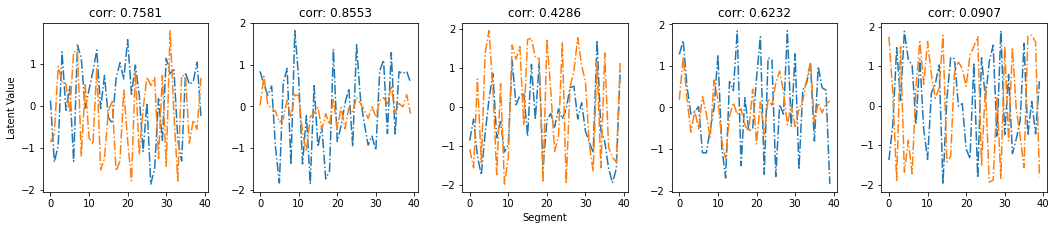

In [28]:
n, n_segments = u.shape
points_per_seg = n // n_segments

# Get correlation coefficients
corr_coefs = correlation_coefficients(s, z_est)

n, n_segments = u.shape
mean_source = np.zeros((5, n_segments))
mean_est = np.zeros((5, n_segments))

for i in range(n_segments):
    for dim in range(5):
        mean_source[dim][i] = np.mean(s[i*points_per_seg:(i+1)*points_per_seg, [dim]])
        mean_est[dim][i] = np.mean(z_est[i*points_per_seg:(i+1)*points_per_seg, [dim]])

# Standardize both signals (mean=0, std=1)
mean_source = (mean_source - np.mean(mean_source, axis=0)) / np.std(mean_source, axis=0)
mean_est = (mean_est - np.mean(mean_est, axis=0)) / np.std(mean_est, axis=0)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=0.05)

for i in range(5):
    axes[i].plot(mean_source[i], linestyle='-.')
    axes[i].plot(mean_est[i], linestyle='-.')
    axes[i].set_title("corr: " + str(round(corr_coefs[i], 4)))
    
axes[2].set_xlabel('Segment')
axes[0].set_ylabel('Latent Value')
plt.show()
fig.savefig('results/mcc_across_dims/' + "_".join([model.__class__.__name__, data_args]))



### OLD Visualizations: 1000 points and 40 segments, plot 40 latent-source point pairs + total CC score

MCC =  0.5198973320410384


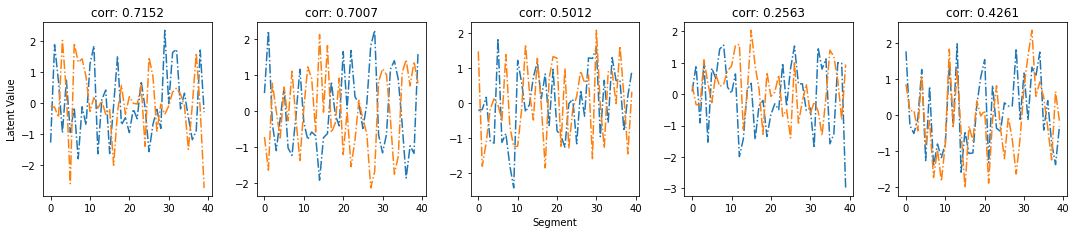

In [10]:
n, n_segments = u.shape
points_per_seg = n // n_segments
source = s
est = z_est

# Get correlation coefficients
corr_coefs, _ = correlation_coefficients(source, est)
print('MCC = ', mcc(source, est))

# Standardize both signals (mean=0, std=1)
source = (source - np.mean(source, axis=0)) / np.std(source, axis=0)
est = (est - np.mean(est, axis=0)) / np.std(est, axis=0)

# Only keep 1 sample per segment (instead of 1000)
source_subset = np.zeros((40, 5))
est_subset = np.zeros((40, 5))
for i in range(n_segments):
    
    source_subset[i] = source[i*points_per_seg + 42, :]
    est_subset[i] = est[i*points_per_seg + 42, :]
    

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.tight_layout()

for i in range(5):
    axes[i].plot(source_subset[:, i], linestyle='-.')
    axes[i].plot(est_subset[:, i], linestyle='-.')
    axes[i].set_title("corr: " + str(round(corr_coefs[i], 4)))
axes[2].set_xlabel('Segment')
axes[0].set_ylabel('Latent Value')
plt.show()



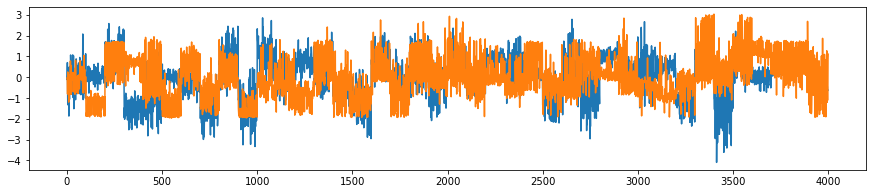

In [43]:
# plt.figure(figsize=(15, 3))
# plt.plot(source[:, 1])
# plt.plot(est[:, 1])
# plt.show()

#### Outdated: For 40 segmends and 1 point per segment, totalling 40 sample latent-source pairs

In [50]:
# Get correlation coefficients
corr_coefs, _ = correlation_coefficients(s, z_est)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.tight_layout()

for i in range(5):
    source = s[:, [i]]
    est = z_est[:, [i]]

    # Standardize both signals (mean=0, std=1)
    source = (source - np.mean(source)) / np.std(source)
    est = (est - np.mean(est)) / np.std(est)
    
    axes[i].plot(source, linestyle='-.')
    axes[i].plot(est, linestyle='-.')
    axes[i].set_title("corr: " + str(round(corr_coefs[i], 4)))
plt.show()

#######################
# Some notable differences:
# A sign flip, original authors might have removed any permutations (sign-flips) already such that negative 
# correlations are avoided in the plotted Figures.

# The signals in our Figures are less aligned.